# **Stock-27**

## **Importing Data**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from matplotlib.ticker import StrMethodFormatter
from bokeh.plotting import figure, show
from bokeh.models import Legend
from bokeh.io import output_notebook

In [2]:
df_raw = pd.read_csv("./Data/individual_book_train/stock_27.csv")

## **Raw Data Info**

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873499 entries, 0 to 873498
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            873499 non-null  int64  
 1   seconds_in_bucket  873499 non-null  int64  
 2   bid_price1         873499 non-null  float64
 3   ask_price1         873499 non-null  float64
 4   bid_price2         873499 non-null  float64
 5   ask_price2         873499 non-null  float64
 6   bid_size1          873499 non-null  int64  
 7   ask_size1          873499 non-null  int64  
 8   bid_size2          873499 non-null  int64  
 9   ask_size2          873499 non-null  int64  
 10  stock_id           873499 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 73.3 MB


## **Feature Engineering**

In [8]:
df = df_raw.copy()

Generating Midpoint1, Midpoint2, Bid-Ask-Spread1, Bid-Ask-Spread2, Log-Returns

In [9]:
df["midpoint1"] = (df["ask_price1"] + df["bid_price1"])/2
df["midpoint2"] = (df["ask_price2"] + df["bid_price2"])/2

df["bid_ask_spread1"] = df["ask_price1"] - df["bid_price1"]
df["bid_ask_spread2"] = df["ask_price2"] - df["bid_price2"]

df['log_return'] = np.log(df['midpoint1'] / df['midpoint1'].shift(1))
df = df.dropna(subset=['log_return'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873498 entries, 1 to 873498
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            873498 non-null  int64  
 1   seconds_in_bucket  873498 non-null  int64  
 2   bid_price1         873498 non-null  float64
 3   ask_price1         873498 non-null  float64
 4   bid_price2         873498 non-null  float64
 5   ask_price2         873498 non-null  float64
 6   bid_size1          873498 non-null  int64  
 7   ask_size1          873498 non-null  int64  
 8   bid_size2          873498 non-null  int64  
 9   ask_size2          873498 non-null  int64  
 10  stock_id           873498 non-null  int64  
 11  midpoint1          873498 non-null  float64
 12  midpoint2          873498 non-null  float64
 13  bid_ask_spread1    873498 non-null  float64
 14  bid_ask_spread2    873498 non-null  float64
 15  log_return         873498 non-null  float64
dtypes: floa

## **Grid Search for Rolling Realized Volatility**

> Warning: This code takes time to run and is not realted to main code, so can be skipped.

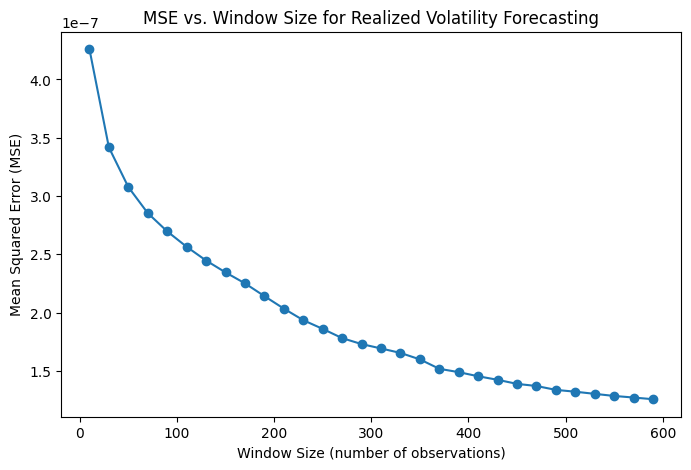

In [10]:
window_sizes = range(10, 600, 20)
results = []

for w in window_sizes:
    col_name = f'rolling_rv_{w}'
    df[col_name] = df['log_return'].rolling(window=w).apply(lambda x: np.sqrt(np.sum(x**2)), raw=True)
    df[f'forecast_{w}'] = df[col_name].shift(1)
    valid = df.dropna(subset=[col_name, f'forecast_{w}'])
    mse = np.mean((valid[col_name] - valid[f'forecast_{w}'])**2)
    results.append({'window_size': w, 'mse': mse})

results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.plot(results_df['window_size'], results_df['mse'], marker='o')
plt.xlabel('Window Size (number of observations)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Window Size for Realized Volatility Forecasting')
plt.show()

## **Feature Engineering**

Generating Features Rolling Realized Volatility, Integrated Variance, Integrated Volatility, Normalized-BAS1, Normalized-BAS2, Order-Book-Imbalance

In [15]:
window_size = 100
def realized_volatility(returns):
    return np.sqrt(np.sum(returns ** 2))

df['realized_volatility'] = df['log_return'].rolling(window=window_size).apply(realized_volatility, raw=True)

df = df.dropna()

In [11]:
df['integrated_variance'] = (df['log_return'] ** 2).cumsum()
df['integrated_volatility'] = np.sqrt(df['integrated_variance'])

In [12]:
df["normalized_spread1"] = df["bid_ask_spread1"]/df["midpoint1"]
df["normalized_spread2"] = df["bid_ask_spread2"]/df["midpoint2"]

In [13]:
df["order_book_imbalance"] = df["bid_ask_spread1"]/df["bid_ask_spread2"]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873399 entries, 100 to 873498
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time_id                873399 non-null  int64  
 1   seconds_in_bucket      873399 non-null  int64  
 2   bid_price1             873399 non-null  float64
 3   ask_price1             873399 non-null  float64
 4   bid_price2             873399 non-null  float64
 5   ask_price2             873399 non-null  float64
 6   bid_size1              873399 non-null  int64  
 7   ask_size1              873399 non-null  int64  
 8   bid_size2              873399 non-null  int64  
 9   ask_size2              873399 non-null  int64  
 10  stock_id               873399 non-null  int64  
 11  midpoint1              873399 non-null  float64
 12  midpoint2              873399 non-null  float64
 13  bid_ask_spread1        873399 non-null  float64
 14  bid_ask_spread2        873399 non-null 

## **Grid Search For Adverse Cost Delta**

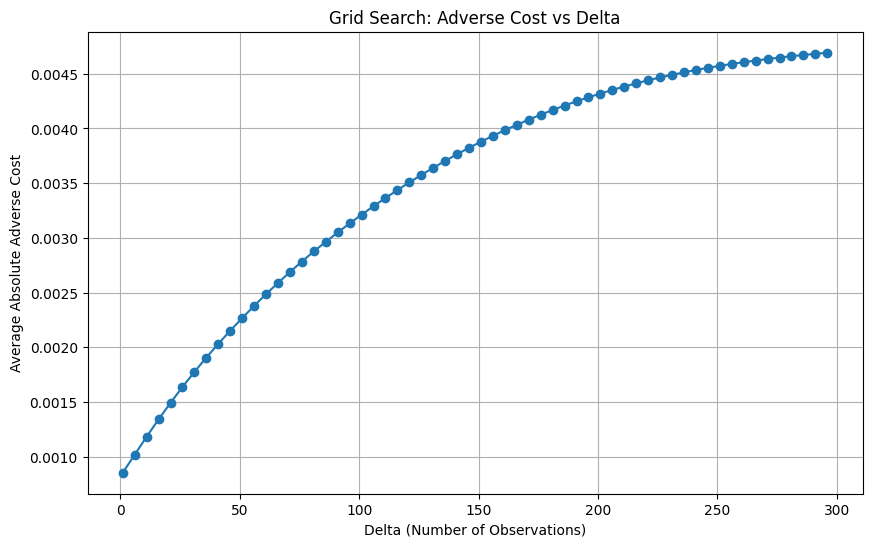

In [17]:
delta_values = range(1, 301, 5)
results = []

for delta in delta_values:
    temp_df = df.copy()
    temp_df['future_midpoint'] = temp_df['midpoint1'].shift(-delta)
    temp_df['adverse_cost_buy'] = temp_df['future_midpoint'] - temp_df['ask_price1']
    avg_abs_cost = temp_df['adverse_cost_buy'].abs().mean()
    results.append({'delta': delta, 'avg_abs_adverse_cost': avg_abs_cost})

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['delta'], results_df['avg_abs_adverse_cost'], marker='o')
plt.xlabel('Delta (Number of Observations)')
plt.ylabel('Average Absolute Adverse Cost')
plt.title('Grid Search: Adverse Cost vs Delta')
plt.grid(True)
plt.show()

## **Feature Engineering**

Generating Future-Midpoint, Adverse-Cost-Buy, Adverse-Cost-Sell, Cumulative-OBI, LOB Entropy, LOB_entropy_normalized, and Microprice

In [17]:
delta = 5

df['future_midpoint'] = df['midpoint1'].shift(-delta)
df['adverse_cost_buy'] = df['future_midpoint'] -  df['ask_price1']
df['adverse_cost_sell'] = df['bid_price1'] - df['future_midpoint']

In [24]:
df["cumulative_order_book_imbalance"] = df["order_book_imbalance"].cumsum()
df = df.dropna()

In [19]:
def compute_lob_entropy(row, normalize=False):
    volumes = np.array([row['bid_size1'], row['bid_size2'], row['ask_size1'], row['ask_size2']], dtype=float)
    total_volume = volumes.sum()
    if total_volume == 0:
        return 0.0
    p = volumes / total_volume
    p = p[p > 0]
    entropy = -np.sum(p * np.log(p))
    
    if normalize:
        entropy /= np.log(4)
    return entropy

df['LOB_entropy'] = df.apply(compute_lob_entropy, axis=1)
df['LOB_entropy_normalized'] = df.apply(lambda row: compute_lob_entropy(row, normalize=True), axis=1)

In [21]:
df["microprice"] = (df["ask_price1"]*df["bid_size1"] + df["bid_price1"]*df["ask_size1"])/(df["bid_size1"] + df["ask_size1"])

In [22]:
df["lob_slope"] = ((df['ask_price2'] - df['ask_price1']) / (df['ask_size2'] + 1e-9)) - \
    ((df['bid_price1'] - df['bid_price2']) / (df['bid_size2'] + 1e-9))

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873394 entries, 100 to 873493
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   time_id                          873394 non-null  int64  
 1   seconds_in_bucket                873394 non-null  int64  
 2   bid_price1                       873394 non-null  float64
 3   ask_price1                       873394 non-null  float64
 4   bid_price2                       873394 non-null  float64
 5   ask_price2                       873394 non-null  float64
 6   bid_size1                        873394 non-null  int64  
 7   ask_size1                        873394 non-null  int64  
 8   bid_size2                        873394 non-null  int64  
 9   ask_size2                        873394 non-null  int64  
 10  stock_id                         873394 non-null  int64  
 11  midpoint1                        873394 non-null  float64
 12  midpo

## **Additional Features**

In [26]:
df['lob_slope_top2'] = (
    ((df['ask_price2'] - df['ask_price1']) + (df['bid_price1'] - df['bid_price2']))
    / ((df['ask_size2'] + df['ask_size1']) + (df['bid_size1'] + df['bid_size2']))
)

In [27]:
df['trade_sign'] = np.sign(df['log_return'])  # +1 if price up, -1 if price down

In [28]:
df['jump_in_quotes'] = (df['ask_price1'].diff().abs() + df['bid_price1'].diff().abs())

In [39]:
df.dropna(subset=["jump_in_quotes"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873394 entries, 100 to 873493
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   time_id                          873394 non-null  int64  
 1   seconds_in_bucket                873394 non-null  int64  
 2   bid_price1                       873394 non-null  float64
 3   ask_price1                       873394 non-null  float64
 4   bid_price2                       873394 non-null  float64
 5   ask_price2                       873394 non-null  float64
 6   bid_size1                        873394 non-null  int64  
 7   ask_size1                        873394 non-null  int64  
 8   bid_size2                        873394 non-null  int64  
 9   ask_size2                        873394 non-null  int64  
 10  stock_id                         873394 non-null  int64  
 11  midpoint1                        873394 non-null  float64
 12  midpo

## **Plotting**

In [33]:
def plot_all_features_and_save(df, save_folder='./cache/Plots'):
    """
    For each column in df, create:
      - A histogram (saved as {column}_hist.png)
      - A time-series line plot (saved as {column}_time_series.png)
    All plots will be saved under 'save_folder'.
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for col in df.columns:
        plt.figure()
        df[col].plot(kind='hist', bins=50)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        
        hist_filename = os.path.join(save_folder, f"{col}_hist.png")
        plt.savefig(hist_filename, dpi=300, bbox_inches='tight')
        plt.close()
        
        plt.figure()
        df[col].plot()
        plt.title(f"Time Series of {col}")
        plt.xlabel("Index (row)")
        plt.ylabel(col)
        
        time_filename = os.path.join(save_folder, f"{col}_time_series.png")
        plt.savefig(time_filename, dpi=300, bbox_inches='tight')
        plt.close()


plot_all_features_and_save(df)

## **Correlation heatmap**

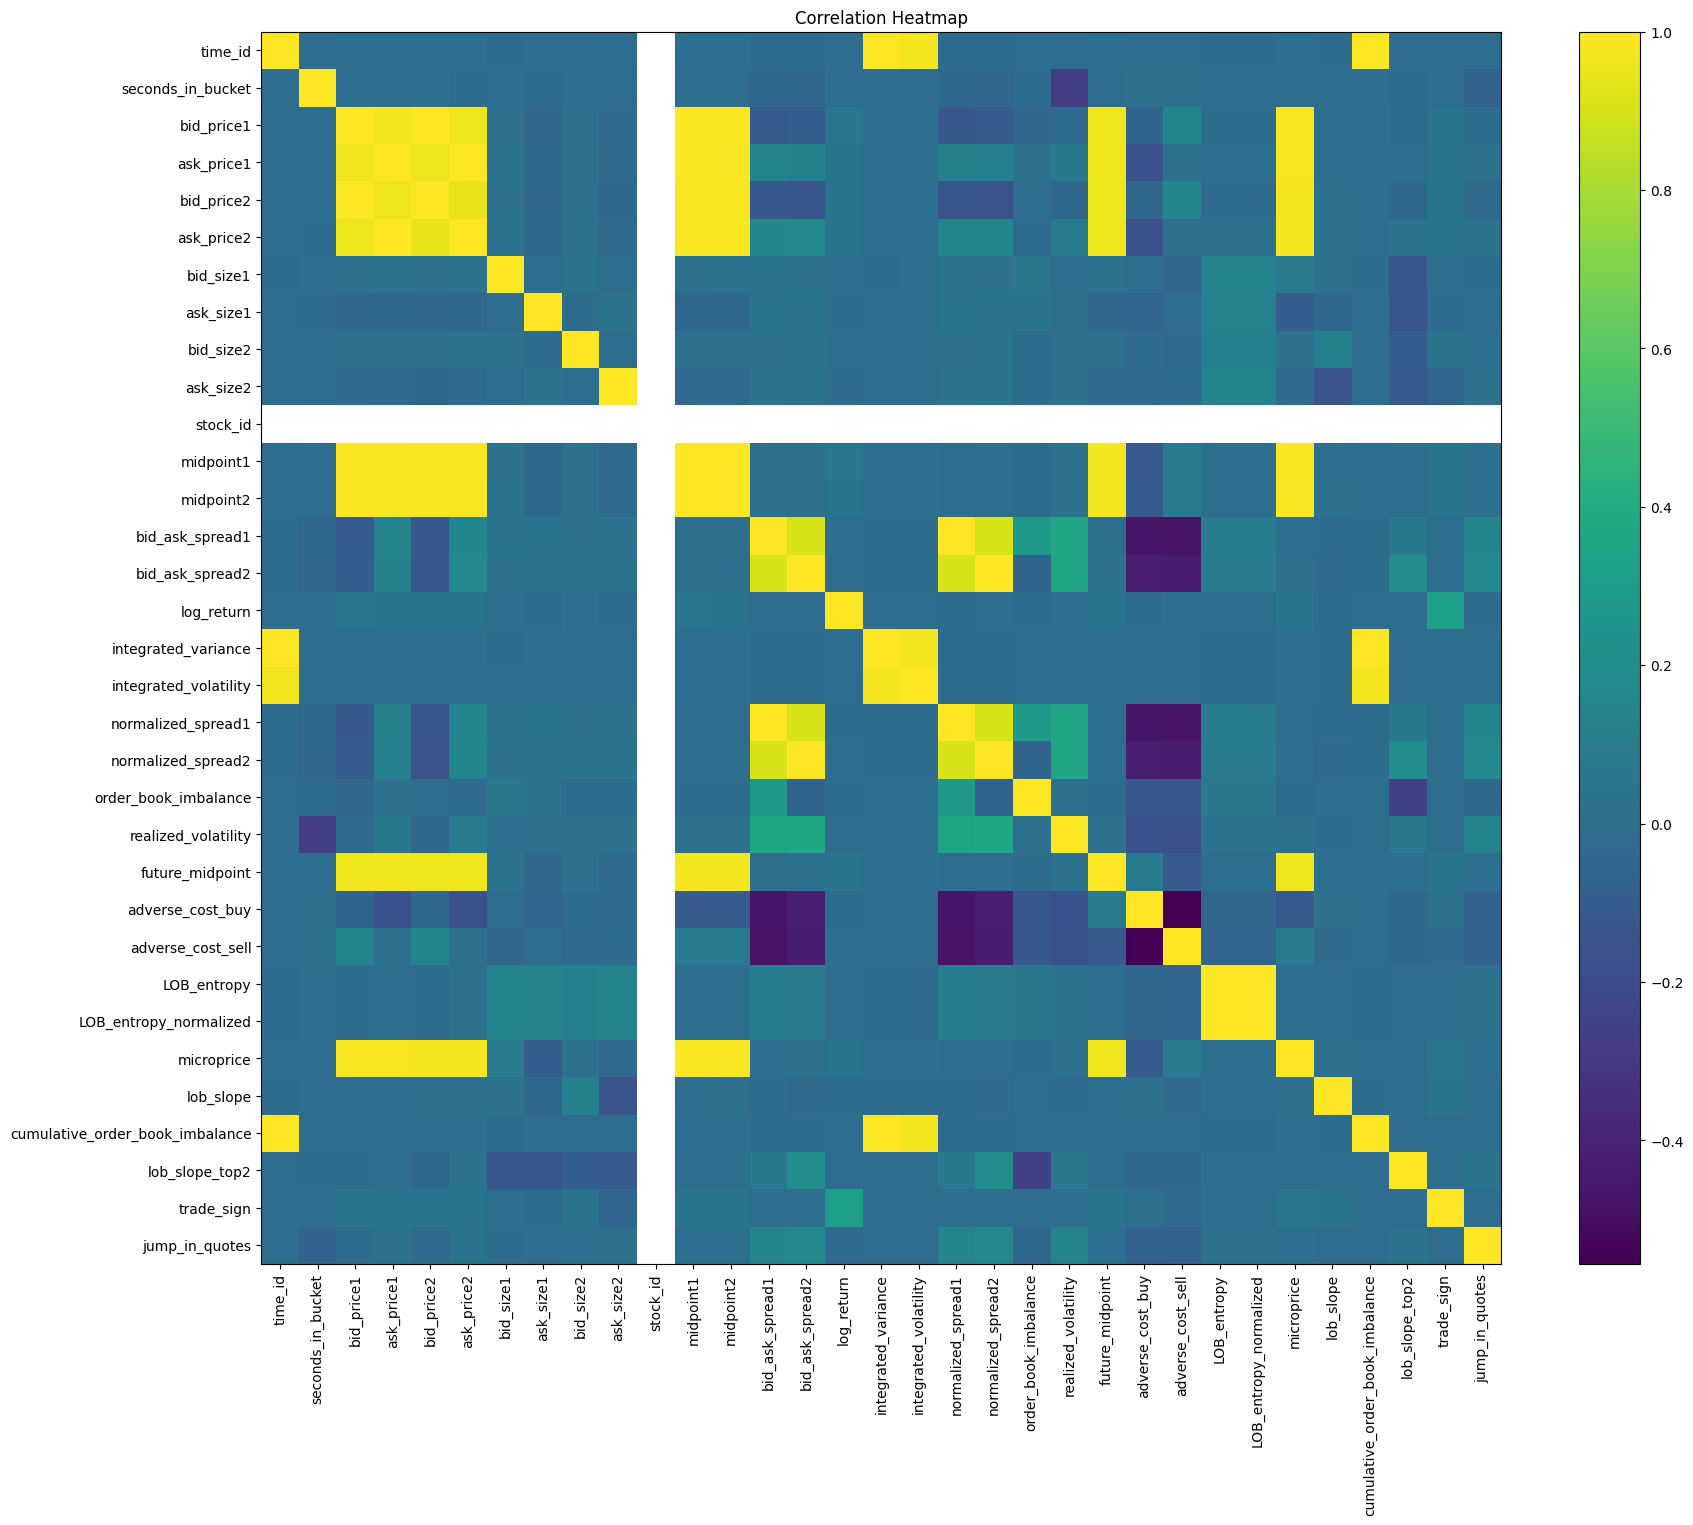

<Figure size 2000x1600 with 0 Axes>

In [31]:
def plot_correlation_heatmap(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(20, 16))
    im = plt.imshow(corr_matrix, aspect='auto')
    plt.title("Correlation Heatmap")
    plt.colorbar(im)
    num_cols = len(corr_matrix.columns)
    plt.xticks(range(num_cols), corr_matrix.columns, rotation=90)
    plt.yticks(range(num_cols), corr_matrix.columns)

    plt.figure(figsize=(20, 16))
    plt.show()

plot_correlation_heatmap(df)


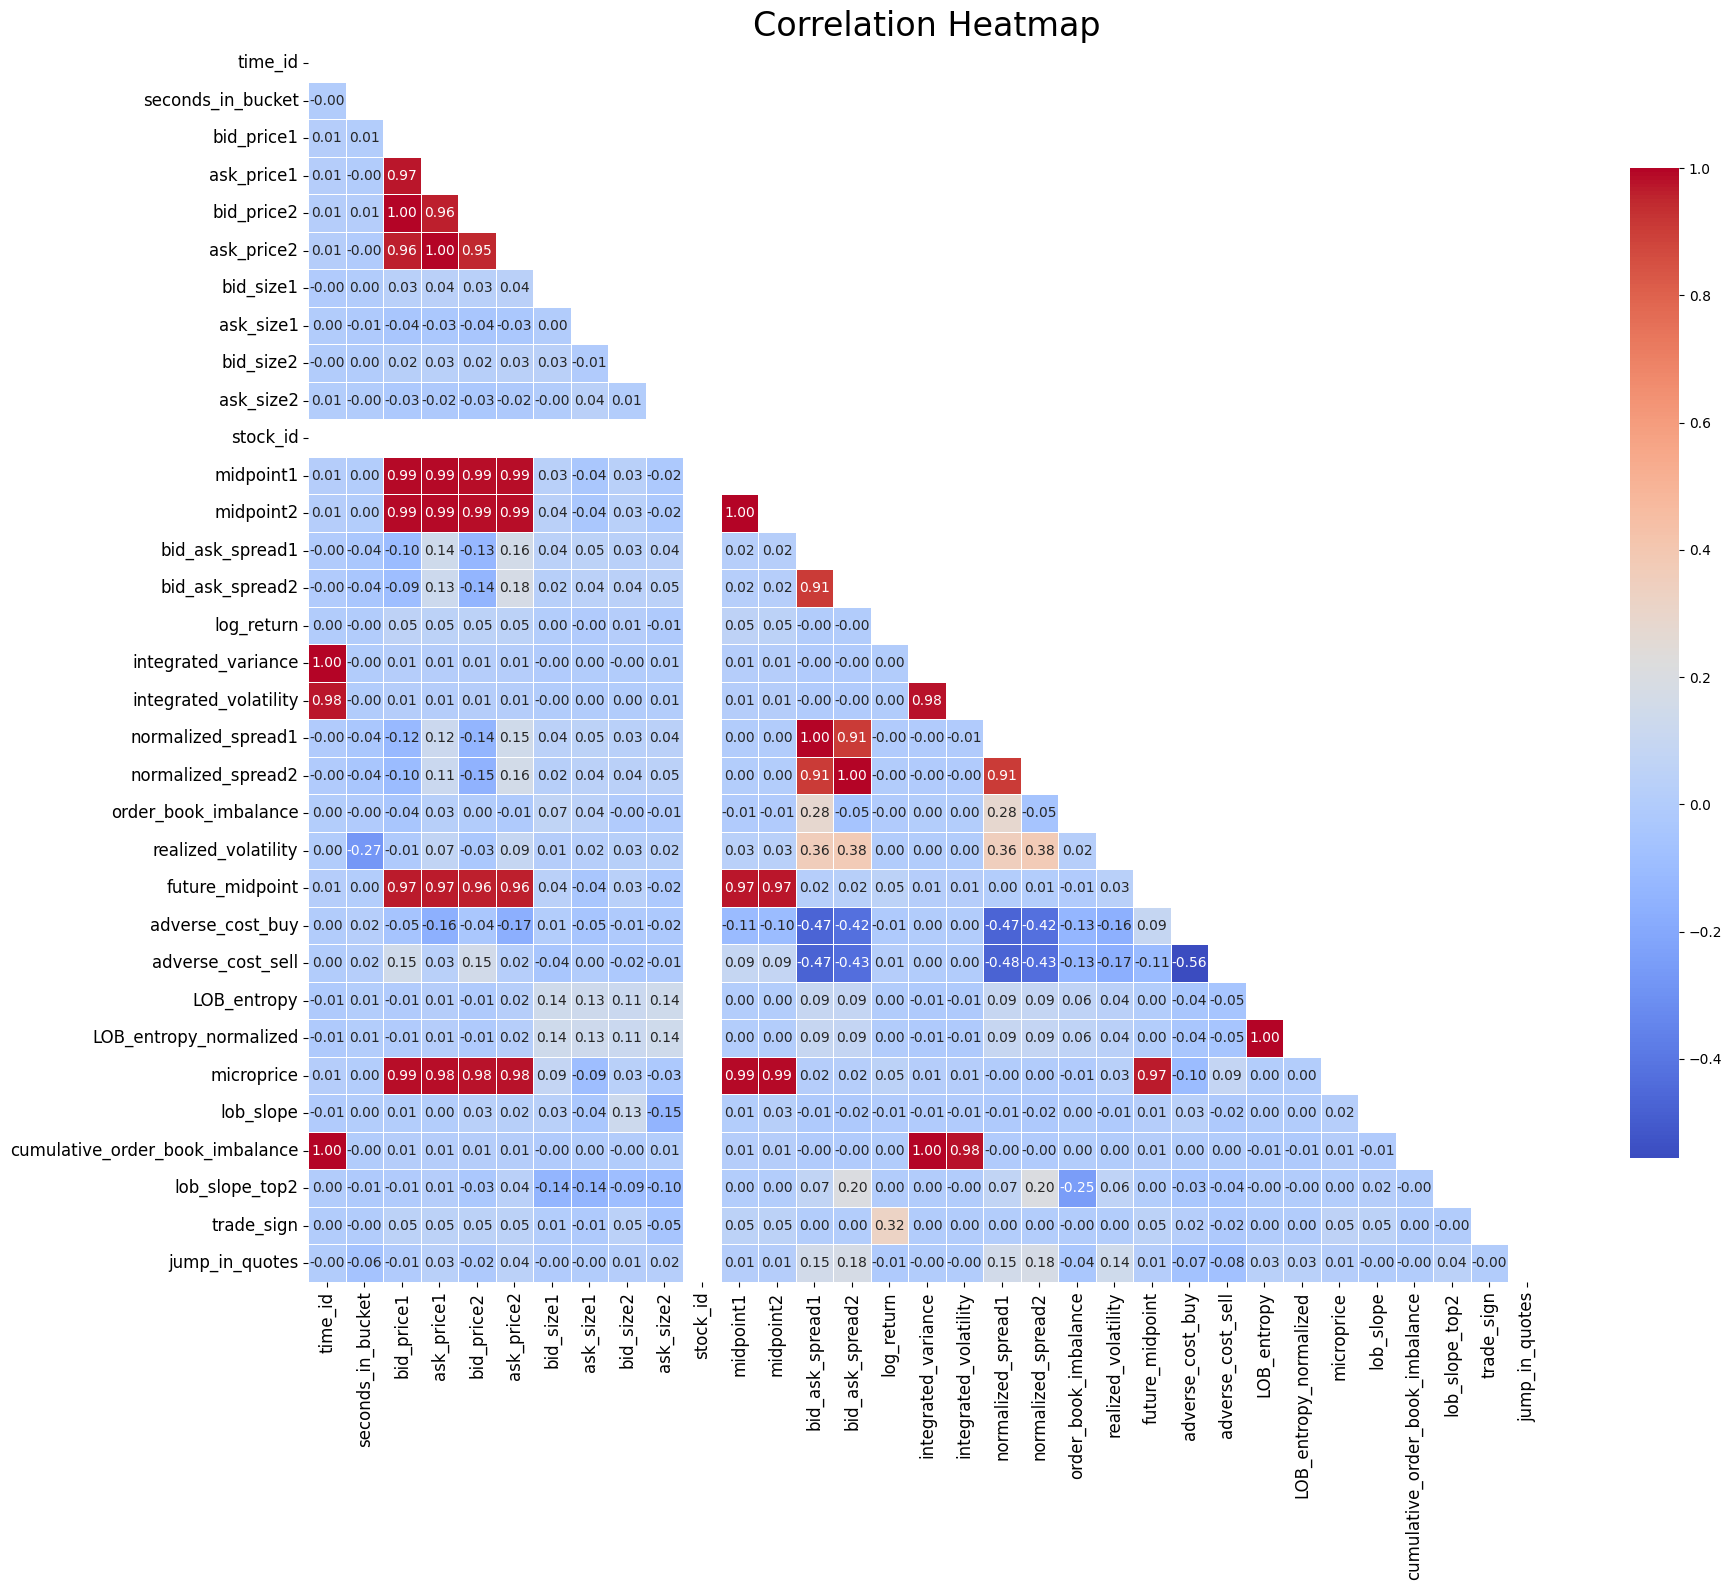

In [32]:
def plot_correlation_heatmap(df):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", mask=mask, cmap='coolwarm',
                linewidths=0.5, linecolor='white', square=True, cbar_kws={"shrink": 0.8})
    
    plt.title("Correlation Heatmap", fontsize=24)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(df)


In [3]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=100, delta=5):
        self.window_size = window_size
        self.delta = delta

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        # Compute midpoints
        df["midpoint1"] = (df["ask_price1"] + df["bid_price1"]) / 2.0
        df["midpoint2"] = (df["ask_price2"] + df["bid_price2"]) / 2.0

        # Compute bid-ask spreads
        df["bid_ask_spread1"] = df["ask_price1"] - df["bid_price1"]
        df["bid_ask_spread2"] = df["ask_price2"] - df["bid_price2"]

        # Log returns
        df["log_return"] = np.log(df["midpoint1"] / df["midpoint1"].shift(1))

        # Realized volatility using rolling window
        df["realized_volatility"] = df["log_return"].rolling(window=self.window_size).apply(
            lambda x: np.sqrt(np.sum(x ** 2)), raw=True
        )

        # Integrated variance and volatility
        df["integrated_variance"] = (df["log_return"] ** 2).cumsum()
        df["integrated_volatility"] = np.sqrt(df["integrated_variance"])

        # Normalized spreads and order book imbalance
        df["normalized_spread1"] = df["bid_ask_spread1"] / df["midpoint1"]
        df["normalized_spread2"] = df["bid_ask_spread2"] / df["midpoint2"]
        df["order_book_imbalance"] = df["bid_ask_spread1"] / df["bid_ask_spread2"]
        df["cumulative_order_book_imbalance"] = df["order_book_imbalance"].cumsum()

        # Future midpoint and adverse costs
        df["future_midpoint"] = df["midpoint1"].shift(-self.delta)
        df["adverse_cost_buy"] = df["future_midpoint"] - df["ask_price1"]
        df["adverse_cost_sell"] = df["bid_price1"] - df["future_midpoint"]

        # Vectorized computation of LOB entropy
        lob_columns = ["bid_size1", "bid_size2", "ask_size1", "ask_size2"]
        volumes = df[lob_columns].values.astype(float)
        total_volume = volumes.sum(axis=1, keepdims=True)
        # Avoid division by zero using np.errstate
        with np.errstate(divide="ignore", invalid="ignore"):
            p = np.divide(volumes, total_volume, where=total_volume != 0)
        # Set probabilities to zero for rows with no volume
        p = np.where(total_volume == 0, 0, p)
        # Compute entropy in a vectorized way; avoid log(0) issues
        entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
        df["LOB_entropy"] = entropy
        # Normalize by maximum entropy for 4 levels
        df["LOB_entropy_normalized"] = entropy / np.log(4)

        # Additional features: microprice and LOB slopes
        df["microprice"] = (
            (df["ask_price1"] * df["bid_size1"] + df["bid_price1"] * df["ask_size1"])
            / (df["bid_size1"] + df["ask_size1"])
        )
        df["lob_slope"] = (
            ((df["ask_price2"] - df["ask_price1"]) / (df["ask_size2"] + 1e-9))
            - ((df["bid_price1"] - df["bid_price2"]) / (df["bid_size2"] + 1e-9))
        )
        df["lob_slope_top2"] = (
            ((df["ask_price2"] - df["ask_price1"]) + (df["bid_price1"] - df["bid_price2"]))
            / ((df["ask_size2"] + df["ask_size1"]) + (df["bid_size1"] + df["bid_size2"]))
        )

        # Additional computed features: trade sign and jump in quotes
        df["trade_sign"] = np.sign(df["log_return"])
        df["jump_in_quotes"] = df["ask_price1"].diff().abs() + df["bid_price1"].diff().abs()

        return df.dropna()

feature_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer(window_size=100, delta=5))
])


In [4]:
df = feature_pipeline.fit_transform(df_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873394 entries, 100 to 873493
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   time_id                          873394 non-null  int64  
 1   seconds_in_bucket                873394 non-null  int64  
 2   bid_price1                       873394 non-null  float64
 3   ask_price1                       873394 non-null  float64
 4   bid_price2                       873394 non-null  float64
 5   ask_price2                       873394 non-null  float64
 6   bid_size1                        873394 non-null  int64  
 7   ask_size1                        873394 non-null  int64  
 8   bid_size2                        873394 non-null  int64  
 9   ask_size2                        873394 non-null  int64  
 10  stock_id                         873394 non-null  int64  
 11  midpoint1                        873394 non-null  float64
 12  midpo

## **EDA**

In [7]:
def makeHist(df: pd.DataFrame, colname: str, histBin: int, gridStat: bool) -> None:

    ax = df.hist(column=colname, bins=histBin, grid=gridStat, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
    ax = ax[0]
    for x in ax:
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
        x.set_title(colname)
        plt.savefig(f"./cache/histograms/{colname}.png", dpi=300, bbox_inches='tight')
        plt.close()

for i in df.columns:
    makeHist(df, i, 100, False)

In [8]:
print("Unique time_ids:", df['time_id'].unique())
print("Number of unique time_ids:", df['time_id'].nunique())
corr_matrix = df.corr()
# Let's find pairs of strongly correlated features
strong_pairs = []
threshold = 0.7
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 < col2:  # to avoid repeats
            if abs(corr_matrix.loc[col1, col2]) > threshold:
                strong_pairs.append((col1, col2, corr_matrix.loc[col1, col2]))

strong_pairs

Unique time_ids: [    5    11    16 ... 32758 32763 32767]
Number of unique time_ids: 3830


[('bid_price1', 'bid_price2', np.float64(0.9954279754385347)),
 ('bid_price1', 'midpoint1', np.float64(0.9926363837783562)),
 ('bid_price1', 'midpoint2', np.float64(0.9906813481580564)),
 ('bid_price1', 'future_midpoint', np.float64(0.9666824701021547)),
 ('bid_price1', 'microprice', np.float64(0.9852618767932423)),
 ('ask_price1', 'bid_price1', np.float64(0.9707853505256683)),
 ('ask_price1', 'bid_price2', np.float64(0.9606799791608985)),
 ('ask_price1', 'ask_price2', np.float64(0.9955769619374016)),
 ('ask_price1', 'midpoint1', np.float64(0.9927024805815847)),
 ('ask_price1', 'midpoint2', np.float64(0.9905948267349935)),
 ('ask_price1', 'future_midpoint', np.float64(0.9671103628976789)),
 ('ask_price1', 'microprice', np.float64(0.9845042981639275)),
 ('bid_price2', 'midpoint1', np.float64(0.9852372327998447)),
 ('bid_price2', 'midpoint2', np.float64(0.987390747255959)),
 ('bid_price2', 'future_midpoint', np.float64(0.9604526595820867)),
 ('bid_price2', 'microprice', np.float64(0.9791

In [ ]:
output_notebook()

p = figure(title="Bid Price1, Ask Price1, and Midpoint1 Over Index", x_axis_label='Index', y_axis_label='Price', width=800, height=400)

r1 = p.line(df.index, df['bid_price1'], color="blue", legend_label="Bid Price1", line_width=1)
r2 = p.line(df.index, df['ask_price1'], color="red", legend_label="Ask Price1", line_width=1)
r3 = p.line(df.index, df['midpoint1'], color="green", legend_label="Midpoint1", line_width=1)

p.legend.location = "top_left"
show(p)